In [1]:
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import astropy.visualization.wcsaxes as wcsaxes
from astropy.utils.data import download_file
from get_cubeinfo import get_cubeinfo
from colormaps import cmaps

%matplotlib inline

In [34]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 10,7
plt.rcParams['font.size'] = 15
plt.rcParams['lines.markersize'] = 100
plt.rcParams['axes.labelsize'] = "medium"
plt.rcParams['axes.titlesize'] = "x-large"
plt.rcParams['axes.titleweight'] = "heavy"
plt.rcParams['figure.autolayout'] = True
plt.rcParams['legend.frameon'] = False

In [2]:
#Constants
c = 2.998e5 # Speed of light [km/s]
lam_CaII = 3969.591
lam_NaI = 5897.5581

In [3]:
from importBHBdata import *


---------------- CaII IV -------------------
--------------------------------------------

---------------- CaII MW -------------------
--------------------------------------------

---------------- NaI IV --------------------
--------------------------------------------

---------------- NaI MW --------------------
--------------------------------------------

---------------- HI IV ---------------------
--------------------------------------------

---------------- HI MW ---------------------
--------------------------------------------


importBHBdata.py:438: RuntimeWarning: divide by zero encountered in log10
  totalN_Ca_MW = np.log10(nonlogtotal_Ca_MW)
importBHBdata.py:439: RuntimeWarning: divide by zero encountered in log10
  totalN_Ca_IV = np.log10(nonlogtotal_Ca_IV)
importBHBdata.py:440: RuntimeWarning: divide by zero encountered in log10
  totalN_Na_MW = np.log10(nonlogtotal_Na_MW)
importBHBdata.py:441: RuntimeWarning: divide by zero encountered in log10
  totalN_Na_IV = np.log10(nonlogtotal_Na_IV)
importBHBdata.py:443: RuntimeWarning: divide by zero encountered in log10
  totalN_HI_IV = np.log10(nonlogtotal_HI_IV)
importBHBdata.py:445: RuntimeWarning: invalid value encountered in divide
  totalNlowerr_Ca_MW = 0.434*(nonlogNlowerr_Ca_MW/nonlogtotal_Ca_MW)
importBHBdata.py:446: RuntimeWarning: invalid value encountered in divide
  totalNlowerr_Ca_IV = 0.434*(nonlogNlowerr_Ca_IV/nonlogtotal_Ca_IV)
importBHBdata.py:447: RuntimeWarning: invalid value encountered in divide
  totalNlowerr_Na_MW = 0.434*(nonlogNlowerr_N

From Daniel Lenz' code:

In [4]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt


def fetch_data(filename):
    data, header = fits.getdata(filename, header=True)

    # Get HI velocity grid
    _channels = np.arange(1, header["NAXIS3"] + 1)
    velos = (_channels - header["CRPIX3"]) * header["CDELT3"] / 1.0e3  # in km/s

    # Build 2d header
    wcs = WCS(header).celestial
    header_2d = wcs.to_header()

    #print(velos)
    #print(data)
    #print(header_2d)
    #print(wcs)

    return data, header_2d, wcs, velos


def calc_moments(data, velos, cliplevel=0.1):
    """
    Calculates the first two moments of a 3D data cube.

    Parameters
    ----------
    data : np.ndarray
        Input 3D HI data, assumed to be brightness temperature in Kelvin
    velos : np.ndarray
        Radial velocity of the HI data, in km/s. Shape must match data.shape[0]
    cliplevel : float
        The parameter to tune in order to suppress artifacts from noise

    Returns
    -------
    mom0, mom1
        First two moments, units are K.km/s and km/s, respectively
    """

    d_clipped = np.where(data > cliplevel, data, 0.0)
    mom0 = d_clipped.sum(axis=0)
    mom1 = np.sum(velos[:, None, None] * d_clipped, axis=0) / mom0

    return mom0, mom1


def plot_mom1(mom1, header, outname=None):
    wcs = WCS(header)

    fig, ax = plt.subplots(figsize=(36, 24), subplot_kw={"projection": wcs.celestial})

    im = ax.imshow(mom1, origin="lower", interpolation="nearest")

    # Colorbar
    cbar = plt.colorbar(im)
    cbar.set_label(r"$v_{\rm LSR}\ [\rm km/s]$")

    # Grid and labels
    ax.grid(color='black', linestyle='solid')
    ax.set_xlabel(r'$\rm R.A.\ [deg]$')
    ax.set_ylabel(r'$\rm Declination\ [deg]$')

    # Save to disk
    if outname is not None:
        plt.savefig(outname, dpi=300)

    return



def calc_moments_N(data_N, velos_N, cliplevel_N=0.):
    """
    Calculates the first two moments of a 3D data cube.

    Parameters
    ----------
    data : np.ndarray
        Input 3D HI data, assumed to be brightness temperature in Kelvin
    velos : np.ndarray
        Radial velocity of the HI data, in km/s. Shape must match data.shape[0]
    cliplevel : float
        The parameter to tune in order to suppress artifacts from noise

    Returns
    -------
    mom0, mom1
        First two moments, units are K.km/s and km/s, respectively
    """

    d_clipped_N = np.where(data_N > cliplevel_N, data_N, 0.0)
    mom0_N_clipped = d_clipped_N.sum(axis=0)
    mom1_N = np.sum(velos_N[:, None, None] * d_clipped_N, axis=0) / mom0_N_clipped

    return mom0_N_clipped, mom1_N


def plot_mom0(mom0, header, outname=None):
    wcs = WCS(header)

    fig, ax = plt.subplots(figsize=(36, 24), subplot_kw={"projection": wcs.celestial})

    im = ax.imshow(mom0, origin="lower", interpolation="nearest")

    # Colorbar
    cbar = plt.colorbar(im)
    cbar.set_label(r"$N_{\rm HI}\ [\rm cm^{-2}]$")

    # Grid and labels
    ax.grid(color='black', linestyle='solid')
    ax.set_xlabel(r'$\rm R.A.\ [deg]$')
    ax.set_ylabel(r'$\rm Declination\ [deg]$')

    # Save to disk
    if outname is not None:
        plt.savefig(outname, dpi=300)

    return

# For flux-weighted velocity map:

In [5]:
# Load data

input_filename = "ngp_nhi_vel_-60.45_-24.38.fits"

data, header_2d, wcs, velos = fetch_data(input_filename)

In [6]:
# Calculate moments and save to FITS file

output_file = "mom1_vel"

# Calculate moment maps for velocity
mom0, mom1 = calc_moments(data, velos, cliplevel=1.4)

# Save
fits.writeto(output_file + ".fits", mom1, header_2d, overwrite=True)

/Users/hannahbish/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in divide


In [7]:
# Load the fits file you just created

image_file = 'mom1_vel.fits'

data, header = fits.getdata(image_file, header=True)
hdu = fits.open(image_file)[0]

wcs_head = WCS(hdu.header,naxis=2)

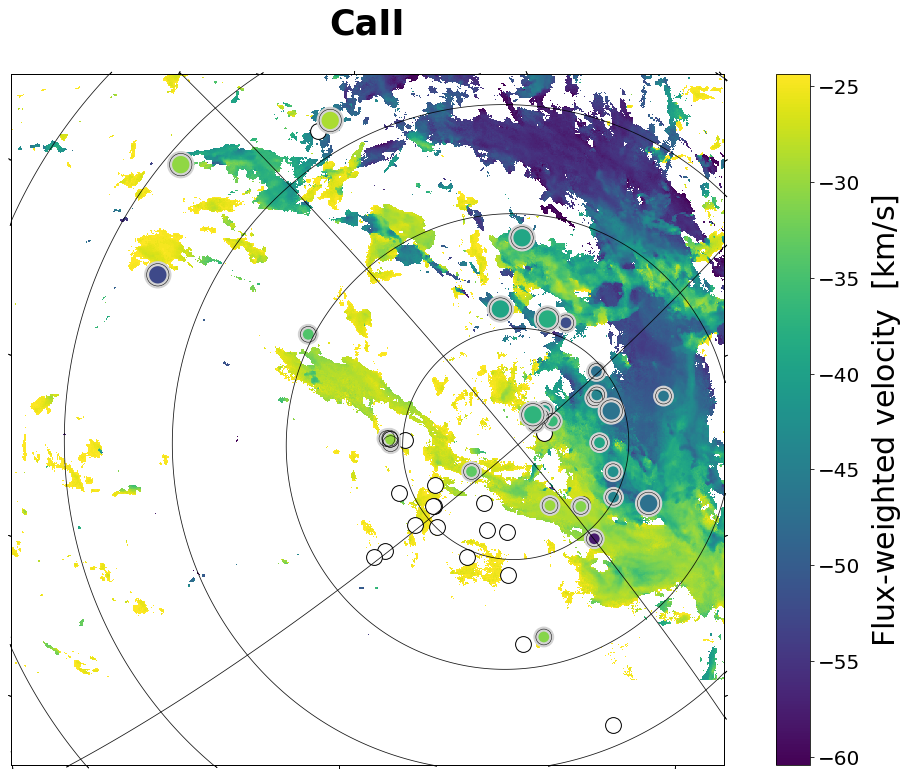

In [102]:
HI_on = False
force_vmin = -60
force_vmax = -25

fig = plt.figure(figsize=(18,12))
ax = fig.add_axes([0.1,0.1,0.8,0.8], projection=wcs_head)

### Plot HI map ###

HI_map = plt.imshow(hdu.data, origin='lower', cmap='viridis')

ax.coords['ra'].set_ticklabel(size=0)
ax.coords['dec'].set_ticklabel(size=0)

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='black', linestyle='solid', alpha=0.9,zorder=0)
overlay[0].set_ticklabel(position='btlr', size=25)
overlay[1].set_ticks(number=None)
overlay[0].set_ticklabel_visible(False)
overlay[1].set_ticklabel_visible(False)


### Plot BHBs ###

if HI_on == False:
    species = 'Ca'
    plt.title(r'CaII',y=1.05,fontsize=35)
    cm = plt.cm.get_cmap('viridis')
    #"""
    #For Ca
    #Plot Ca nondetections
    plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_Ca_IV == 0], Decs[numlines_Ca_IV == 0],1)[0],\
                wcs_head.wcs_world2pix(RAs[numlines_Ca_IV == 0], Decs[numlines_Ca_IV == 0],1)[1],\
                facecolors="white",edgecolors='k',s=250,alpha=1.)
    
    #Plot single Ca detections
    sc = plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_Ca_IV == 1], Decs[numlines_Ca_IV == 1],1)[0],\
                     wcs_head.wcs_world2pix(RAs[numlines_Ca_IV == 1], Decs[numlines_Ca_IV == 1],1)[1],\
                     c=(weightedvel_Ca_IV[numlines_Ca_IV == 1]*np.sin(np.deg2rad(Gal_lat[numlines_Ca_IV == 1])))*1.0,\
                     cmap=cm,s=250,alpha=1.,edgecolors='lightgrey',linewidth=5,\
                     vmin=force_vmin, vmax=force_vmax)
    #Outline single Ca detections
    plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_Ca_IV == 1], Decs[numlines_Ca_IV == 1],1)[0],\
                wcs_head.wcs_world2pix(RAs[numlines_Ca_IV == 1], Decs[numlines_Ca_IV == 1],1)[1],\
                facecolors="None",edgecolors='k',s=250,alpha=1.,linewidth=0.5)
    
    #Plot multiple Ca detections
    sc = plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_Ca_IV > 1], Decs[numlines_Ca_IV > 1],1)[0],\
                     wcs_head.wcs_world2pix(RAs[numlines_Ca_IV > 1], Decs[numlines_Ca_IV > 1],1)[1],\
                     c=(weightedvel_Ca_IV[numlines_Ca_IV > 1]*np.sin(np.deg2rad(Gal_lat[numlines_Ca_IV > 1])))*1.0,\
                     cmap=cm,s=500,alpha=1.,edgecolors='lightgrey',linewidth=5,\
                     vmin=force_vmin, vmax=force_vmax)
    #Outline multiple Ca detections
    plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_Ca_IV > 1], Decs[numlines_Ca_IV > 1],1)[0],\
                wcs_head.wcs_world2pix(RAs[numlines_Ca_IV > 1], Decs[numlines_Ca_IV > 1],1)[1],\
                facecolors="None",edgecolors='k',s=500,alpha=1.,linewidth=0.5)


if HI_on == True:
    species = 'HI'
    plt.title(r'HI',y=1.05,fontsize=35)
    cm = plt.cm.get_cmap('viridis')
    #"""
    #For HI
    #Plot HI nondetections
    plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_HI_IV == 0], Decs[numlines_HI_IV == 0],1)[0],\
                wcs_head.wcs_world2pix(RAs[numlines_HI_IV == 0], Decs[numlines_HI_IV == 0],1)[1],\
                facecolors="white",edgecolors='k',s=250,alpha=1.)
    
    #Plot single HI detections
    sc = plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_HI_IV == 1], Decs[numlines_HI_IV == 1],1)[0],\
                     wcs_head.wcs_world2pix(RAs[numlines_HI_IV == 1], Decs[numlines_HI_IV == 1],1)[1],\
                     c=(weightedvel_HI_IV[numlines_HI_IV == 1]*np.sin(np.deg2rad(Gal_lat[numlines_HI_IV == 1])))*1.0,\
                     cmap=cm,s=250,alpha=1.,edgecolors='lightgrey',linewidth=5,\
                     vmin=force_vmin, vmax=force_vmax)
    #Outline single HI detections
    plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_HI_IV == 1], Decs[numlines_HI_IV == 1],1)[0],\
                wcs_head.wcs_world2pix(RAs[numlines_HI_IV == 1], Decs[numlines_HI_IV == 1],1)[1],\
                facecolors="None",edgecolors='k',s=250,alpha=1.,linewidth=0.5)
    
    #Plot multiple HI detections
    sc = plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_HI_IV > 1], Decs[numlines_HI_IV > 1],1)[0],\
                     wcs_head.wcs_world2pix(RAs[numlines_HI_IV > 1], Decs[numlines_HI_IV > 1],1)[1],\
                     c=(weightedvel_HI_IV[numlines_HI_IV > 1]*np.sin(np.deg2rad(Gal_lat[numlines_HI_IV > 1])))*1.0,\
                     cmap=cm,s=500,alpha=1.,edgecolors='lightgrey',linewidth=5,\
                     vmin=force_vmin, vmax=force_vmax)
    #Outline multiple HI detections
    plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_HI_IV > 1], Decs[numlines_HI_IV > 1],1)[0],\
                wcs_head.wcs_world2pix(RAs[numlines_HI_IV > 1], Decs[numlines_HI_IV > 1],1)[1],\
                facecolors="None",edgecolors='k',s=500,alpha=1.,linewidth=0.5)
    


### Add colorbar ###

cb2 = plt.colorbar(HI_map)
cb2.set_label(label=r'Flux-weighted velocity  $\rm [km/s]$',size=30,labelpad=10)
cb2.ax.tick_params(labelsize=20)


plt.savefig('WCS_vel_'+species+'_-60to-25_Lenz.pdf')
plt.savefig('WCS_vel_'+species+'_-60to-25_Lenz.png')

# For column density map:

In [10]:
# Load data

input_filename_N = "ngp_nhi_vel_-60.45_-24.38.fits"

data_N, header_2d_N, wcs_N, velos_N = fetch_data(input_filename_N)

In [11]:
# Calculate moments and save to FITS file

output_file_N = "mom0_N"

# Calculate moment maps
mom0_N, mom1_N = calc_moments(data_N, velos_N, cliplevel=0.)

# Save
fits.writeto( output_file_N + ".fits", mom0_N, header_2d_N, overwrite=True)

In [12]:
image_file_N = 'mom0_N.fits'

data_N, header_N = fits.getdata(image_file_N, header=True)
hdu_N = fits.open(image_file_N)[0]

wcs_head_N = WCS(hdu_N.header,naxis=2)

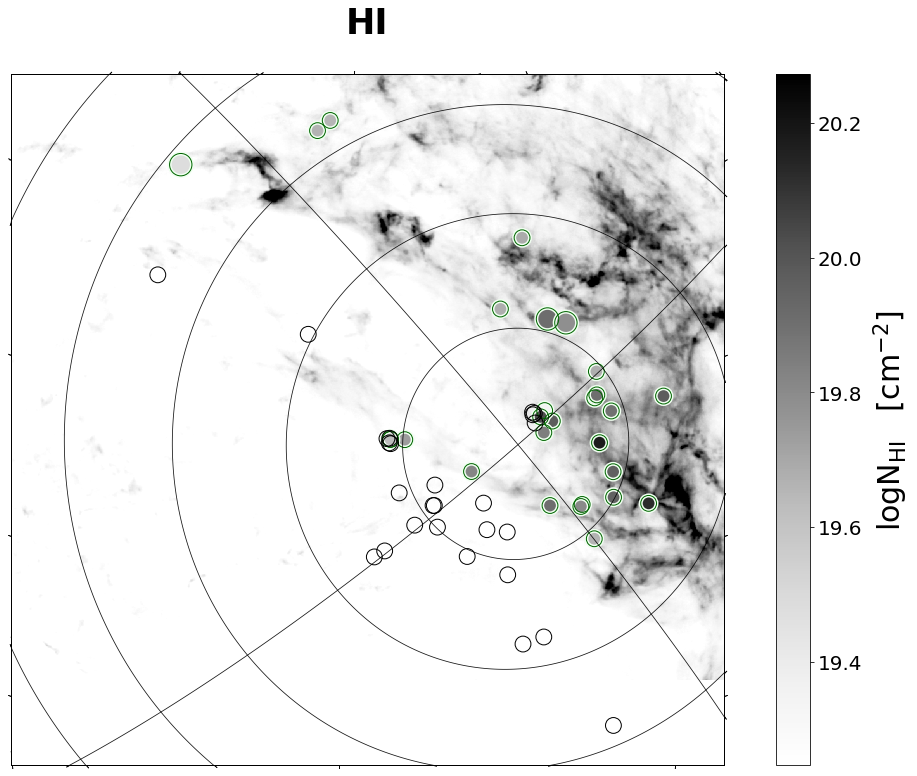

In [94]:
HI_on = True
force_vmax = 12.8

fig = plt.figure(figsize=(18,12))
ax = fig.add_axes([0.1,0.1,0.8,0.8], projection=wcs_head_N)

### Plot HI map ###

HI_map = plt.imshow(hdu_N.data, origin='lower', cmap='Greys',vmin=11, vmax=82) # np.log10(1.823e18*hdu_N.data)

ax.coords['ra'].set_ticklabel(size=0)
ax.coords['dec'].set_ticklabel(size=0)

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='black', linestyle='solid', alpha=0.9,zorder=0)
overlay[0].set_ticklabel(position='tblr', size=25)
overlay[1].set_ticks(number=None)
overlay[0].set_ticklabel_visible(False)
overlay[1].set_ticklabel_visible(False)


### Plot BHBs ###

if HI_on == False:
    species = 'Ca'
    plt.title(r'CaII',y=1.05,fontsize=35)
    cb_label = r'$\rm logN_{Ca II}$   $\rm [cm^{-2}]$'
    cm = plt.cm.get_cmap('Blues')
    #For Ca
    #Plot single Ca detections
    sc = plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_Ca_IV == 1], Decs[numlines_Ca_IV == 1],1)[0],\
                     wcs_head.wcs_world2pix(RAs[numlines_Ca_IV == 1], Decs[numlines_Ca_IV == 1],1)[1],\
                     c=summedN_Ca_IV[numlines_Ca_IV == 1],cmap=cm,s=250,alpha=0.8,edgecolors='k',\
                     vmin=min(summedN_Ca_IV[summedN_Ca_IV != 0])-0.1, vmax=max(summedN_Ca_IV[summedN_Ca_IV != 0])-0.4) # , vmax=max(summedN_Ca_IV[summedN_Ca_IV != 0])+0.1)
    
    #Outline single Ca detections
    plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_Ca_IV == 1], Decs[numlines_Ca_IV == 1],1)[0],\
                wcs_head.wcs_world2pix(RAs[numlines_Ca_IV == 1], Decs[numlines_Ca_IV == 1],1)[1],\
                facecolors="None",edgecolors='k',s=250,alpha=1.)
    
    #Plot multiple Ca detections
    sc = plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_Ca_IV > 1], Decs[numlines_Ca_IV > 1],1)[0],\
                     wcs_head.wcs_world2pix(RAs[numlines_Ca_IV > 1], Decs[numlines_Ca_IV > 1],1)[1],\
                     c=summedN_Ca_IV[numlines_Ca_IV > 1],cmap=cm,s=500,alpha=0.8,edgecolors='k',\
                     vmin=min(summedN_Ca_IV[summedN_Ca_IV != 0])-0.1, vmax=max(summedN_Ca_IV[summedN_Ca_IV != 0])-0.4) # , vmax=max(summedN_Ca_IV[summedN_Ca_IV != 0])+0.1)
    #Outline multiple Ca detections
    plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_Ca_IV > 1], Decs[numlines_Ca_IV > 1],1)[0],\
                wcs_head.wcs_world2pix(RAs[numlines_Ca_IV > 1], Decs[numlines_Ca_IV > 1],1)[1],\
                facecolors="None",edgecolors='k',s=500,alpha=1.)
    
    #Plot Ca non-detections
    plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_Ca_IV == 0], Decs[numlines_Ca_IV == 0],1)[0],\
                wcs_head.wcs_world2pix(RAs[numlines_Ca_IV == 0], Decs[numlines_Ca_IV == 0],1)[1],\
                facecolors="None",edgecolors='k',s=250,alpha=1)

if HI_on == True:
    species = 'HI'
    plt.title(r'HI',y=1.05,fontsize=35)
    cb_label = r'$\rm logN_{HI}$   $\rm [cm^{-2}]$'
    cm = plt.cm.get_cmap('Greys')
    #For HI
    #Plot single HI detections
    sc = plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_HI_IV == 1], Decs[numlines_HI_IV == 1],1)[0],\
                     wcs_head.wcs_world2pix(RAs[numlines_HI_IV == 1], Decs[numlines_HI_IV == 1],1)[1],\
                     c=summedN_HI_IV[numlines_HI_IV == 1],cmap=cm,s=250,alpha=1.,edgecolors='honeydew',linewidth=4,\
                     vmin=min(summedN_HI_IV[summedN_HI_IV != 0])-0.1, vmax=max(summedN_HI_IV[summedN_HI_IV != 0])+0.1)
    #Outline single HI detections
    plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_HI_IV == 1], Decs[numlines_HI_IV == 1],1)[0],\
                wcs_head.wcs_world2pix(RAs[numlines_HI_IV == 1], Decs[numlines_HI_IV == 1],1)[1],\
                facecolors="None",edgecolors='darkgreen',s=250,alpha=1.)
    
    #Plot multiple HI detections
    sc = plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_HI_IV > 1], Decs[numlines_HI_IV > 1],1)[0],\
                     wcs_head.wcs_world2pix(RAs[numlines_HI_IV > 1], Decs[numlines_HI_IV > 1],1)[1],\
                     c=summedN_HI_IV[numlines_HI_IV > 1],cmap=cm,s=500,alpha=1.,edgecolors='honeydew',linewidth=4,\
                     vmin=min(summedN_HI_IV[summedN_HI_IV != 0])-0.1, vmax=max(summedN_HI_IV[summedN_HI_IV != 0])+0.1)
    #Outline multiple HI detections
    plt.scatter(wcs_head.wcs_world2pix(RAs[numlines_HI_IV > 1], Decs[numlines_HI_IV > 1],1)[0],\
                wcs_head.wcs_world2pix(RAs[numlines_HI_IV > 1], Decs[numlines_HI_IV > 1],1)[1],\
                facecolors="None",edgecolors='darkgreen',s=500,alpha=1.)
    
    #Plot HI nondetections
    plt.scatter(wcs_head.wcs_world2pix(RAs[nolineflag_HI_gas == 0], Decs[nolineflag_HI_gas == 0],1)[0],\
                wcs_head.wcs_world2pix(RAs[nolineflag_HI_gas == 0], Decs[nolineflag_HI_gas == 0],1)[1],\
                facecolors="None",edgecolors='k',s=250,alpha=1.)

### Add colorbar ###

cb2 = plt.colorbar(sc)
cb2.set_label(label=cb_label,size=30,labelpad=10)
cb2.ax.tick_params(labelsize=20)

cb2.solids.set_rasterized(True) 
cb2.set_alpha(1)
cb2.draw_all()


# Used this to convert from the T_b value in the datacube and match it to the column density limits I want (by comparing to old WCS plot)
#from matplotlib import ticker
#tick_locator = ticker.MaxNLocator(nbins=50)
#cb2.locator = tick_locator
#cb2.update_ticks()

plt.savefig('WCS_logN'+species+'_-60to-25_Lenz.pdf')
plt.savefig('WCS_logN'+species+'_-60to-25_Lenz.png')